# OPEN CITIES COMPETITION - DAC TEAM

# Chuẩn bị môi trường
Load libs và mount với google drive

In [7]:
#Reload saved data and libs
import cv2
from google.colab.patches import cv2_imshow #Cannot use cv2.imshow
from keras import Model
from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, Dropout, Input,MaxPooling2D, concatenate, UpSampling2D, Lambda, Conv2DTranspose
from keras.layers import ( Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, 
                          Dropout, Flatten, Concatenate, concatenate, Reshape, Activation, Lambda, Conv2DTranspose )
from keras.layers.core import Layer
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.models import load_model
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
import glob, random
from sklearn.metrics import jaccard_score
from random import sample
import matplotlib.pyplot as plt
import tensorflow as tf
from random import choices, choice

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Custom funcs
Hàm load data đã xử lý từ trước. Khi train model thì chạy vòng for để cắt dữ liệu thành từng chunk nhỏ --> train + evaluate (tách train/test thực hiện bằng tay)

Bước xử lý dữ liệu đã được thực hiện từ trước tại https://colab.research.google.com/drive/11YS5h_fMixm9q43oMKbnjzPCTYXhfKpp?authuser=1#scrollTo=Gs9Om7QPguIU.

Đầu vào của file này là các hình ảnh đã được cắt nhỏ 256x256x3.

*Xây dựng hàm training * --> gọi mô hình và training nó, gồm 3 bước:
* B1. Từ tập full dữ liệu, lấy ra một tập mẫu (subset) với kích thước được nhập trước
* B2. Từ tập subset, cắt nhỏ thành nhiều tập chunk
* B3. Tại mỗi thời điểm, chỉ load vào 1 chunk, chia tập này thành 2 phần là train set và validation set
* B4. train tập train với số epoch = 1, sau khi thu được kết quả thì kiểm nghiệm lại với tập validation
* B6. với mỗi global_epoch, lặp lại quá trình cho các chunk, số lượng global_epoch được nhập trước
* B7. kết thúc mỗi global_epoch, lưu lại mô hình theo đường dẫn nhập trước

In [0]:
# Loss function: jaccard distance and jaccard score metrix
def iou_coef(y_true, y_pred, smooth=1):
  y_pred = tf.math.round(y_pred)
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

#define jaccard loss
def jaccard_distance(y_true, y_pred, smooth=100):
  y_pred = tf.math.round(y_pred)
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
  jac = (intersection + smooth) / (sum_ - intersection + smooth)
  return (1 - jac) * smooth

def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
  denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

  return 1 - (numerator + 1) / (denominator + 1)

def dice_crossentropy_loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def load_to_grayim(im_path):
  original_im = cv2.imread(im_path)
  return cv2.cvtColor(original_im, cv2.COLOR_BGR2GRAY)

def get_file_num(path):
  return len(glob.glob( path ) )

def get_subset(im_folder, subset_size = None):
  '''Từ một đường dẫn thư mục chứa ảnh --> lấy ra ngẫu nhiên sample một số ảnh'''
  im_list = glob.glob( im_folder ) 
  if subset_size is not None:
    if subset_size <=1:
      subset_num = subset_size*len(im_list)
    else:
      subset_num = subset_size
    im_list = sample( im_list, subset_size )
  im_list.sort()
  return im_list

def get_dense_subset(im_folder, subset_size = None, dense_min = 0):
  '''Lấy vào subset từ đường dẫn full, với điều kiện mask của nó phải có tỷ lệ công trình xây dựng lớn hơn tỷ lệ min dense_min
  * dense_min: 0-1 float- double, tỷ lệ đặc tối thiểu'''
  im_list = glob.glob( im_folder )
  selected_ims, black_list = [], []
  tried_times = 0
  # chừng nào chưa đủ tập và số lần thử chưa vượt quá 5 lần subset_size thì kiểm tra ảnh + add vào list
  while  len(selected_ims) <=subset_size and tried_times <= subset_size*5:
    # Lấy ngẫu nhiên 1 ảnh chưa lấy bao giờ
    im = []
    while len(im) == 0 :
      im = [i for i in [choice(im_list)] if i not in black_list ]
    im = im[0]
    black_list.append(im)
    mask = load_to_grayim( im.replace('images', 'masks').replace('.png', '_mask.png') )/255
    dense_ratio = np.sum(mask)/(256*256)
    if dense_ratio >= dense_min:
      selected_ims.append( im )
  return selected_ims

def load_train_data( im_list, chunk = (100, 1), eval = 0 ):
  '''Load dữ liệu từ một đường dẫn là folder chứa ảnh, convert thành dạng ma trận và trả về 2 array: 1 của ảnh, 1 của mask
    Tên mask phải bằng tên ảnh + thay thế images bằng masks + kết thúc bằng _mask.pnj
    # Lưu ý pick vị trí chunk là cố định
    * im_list: list, danh sách đường dẫn đến các file
    * chunk: tuple (chunk_size, chunk_position) or None, nếu là None thì load toàn bộ dữ liệu vào, vị trí chunk muốn lấy ra, ví dụ toàn dữ liệu có 10 chunk, mỗi chunk gồm 100 ảnh --> muốn lấy ra chunk nào
    * eval: 0-1, tỷ lệ cắt ra thành evaluate set, nếu = 0 --> không có evaluate set, nếu chạy từ 0-1 --> trả về IM_Train, MSK_Train, IM_EVAL, MSK_EVAL 
    '''
  if chunk is None:
    chunk_size, chunk_pos = len(im_list), 0
  else:
    ( chunk_size, chunk_pos ) = chunk 

  # với từng chunk ảnh, load dữ liệu vào 
  im_num = len(im_list) ## Số lượng ảnh
  chunk_num = round( im_num/chunk_size + 0.5 ) ## Số lượng chunk (làm tròn lên)

  # lấy danh sách ảnh cần lấy ra
  im_sta_pos = chunk_size*chunk_pos## Vị trí bắt đầu
  im_end_pos = min( chunk_size*(chunk_pos +1), im_num) ## vị trí kết thúc
  im_eval_pos = int( im_sta_pos + (1-eval)*(im_end_pos - im_sta_pos) )
  real_chunk_size = im_end_pos - im_sta_pos +1 ## Số lượng ảnh thực tế có của chunk này

  im_load_list = im_list[im_sta_pos:im_end_pos]

  X_train, y_train, X_eval, y_eval = [], [], [], []
  for i in range( real_chunk_size ):
    pos = i+ im_sta_pos -1
    im = im_list[pos]
    im_mask = im.replace('images', 'masks').replace('.png', '_mask.png')
    if pos < im_eval_pos:
      X_train.append( cv2.imread(im) )
      y_train.append( load_to_grayim(im_mask)/255 )
    else:
      X_eval.append( cv2.imread(im) )
      y_eval.append( load_to_grayim(im_mask)/255 )
  
  X_train = np.array(X_train)
  X_eval = np.array(X_eval)

  y_train = np.array(y_train).reshape( len(y_train), 256, 256, 1 )
  y_eval = np.array(y_eval).reshape( len(y_eval), 256, 256, 1 )

  if eval != 0:
    return X_train, y_train, X_eval, y_eval
  else:
    return X_train, y_train

def evaluate_array_results(model, X, Y):
  '''Đánh giá kết quả mô hình, dựa vào dữ liệu đầu vào là dạng ma trận, X, y trong đó y đã sử lý về dạng 0-1'''
  jaccards = []
  for i in range(len(X)):
    x = X[i]
    y_true = Y[i].reshape(256,256)
    y_pred = np.around( model.predict(x.reshape(1,256,256,3)))[0].reshape(256,256)
    jaccards.append( jaccard_score(y_true, y_pred, average= 'micro') )

    # Show image
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
    ax1.imshow( x )
    ax2.imshow( y_true*255 )
    ax3.imshow( y_pred*255 )
  print('Average jaccards:', np.mean( jaccards ))
  return np.mean( jaccards )  

def evaluate_folder(model, im_list):
  '''Đánh giá mô hình, dữ liệu đầu vào là danh sách đường dẫn các ảnh x, y của tập dl test '''
  X, y_true = load_train_data(im_list, chunk = None, eval = 0)
  return evaluate_array_results(model, X, y_true)
    
def run_train(model, im_list, chunk_size = 100, eval = 0.1, epochs = 10, chunk_epochs = 1, batch_size = 1, save_path = None):
  '''Chạy thực hiện fit'''
  subset_size = len(im_list)
  for epoch in range(epochs):
    # Loop qua từng epoch --> mỗi epoch train hết toàn bộ subset
    for i in range( round( subset_size/chunk_size +0.49999999999999 ) ):
      # Loop qua từng chunk --> training cho từng chunk
      print('-'*10+' Training at global epoch: ',epoch +1,' / ', epochs, ', chunk: ', i+1, '/ ', round( subset_size/chunk_size +0.5 ), '-'*10)
      X_train, y_train, X_eval, y_eval = load_train_data(im_list, chunk= (chunk_size, i), eval = eval )
      history = model.fit(X_train, y_train, batch_size, epochs= chunk_epochs, validation_data = (X_eval, y_eval))
    # Kết thúc mỗi epoch thì lưu lại model 1 lần
    model.save(save_path)
  return history

def run_model(model, im_folder, chunk_size = 100, eval = 0.1, subset_size = 1000, epochs = 10, chunk_epochs =1, batch_size = 1, save_path = None, test_size = 0.1, dense_min = None):
  '''Chạy mô hình: lấy subset + tách train/test + train'''
  # B1. Cắt lấy subset
  print('-'*10+'['+'B1. Cắt lấy subset'+']'+'-'*10)
  if subset_size is None:
    subset_size = get_file_num(im_folder)
  if dense_min is None:
    im_list = get_subset(im_folder, subset_size)
  else:
    im_list = get_dense_subset(im_folder, subset_size, dense_min = dense_min)

  # B2. Tách train/test
  print('-'*10+'['+'B2. Tách train/test'+']'+'-'*10)
  test_num = int( test_size*subset_size) ## số lượng ảnh trong subset
  im_test = sample(im_list, test_num) ## list các ảnh nằm trong test set 
  im_train = [i for i in im_list if i not in im_test] ## list các ảnh nằm trong train set

  # B3. Training và lưu lại kết quả
  print('-'*10+'['+'B3. Training và lưu lại kết quả'+']'+'-'*10)
  run_train( model, im_list = im_train, chunk_size = chunk_size, eval = eval, epochs = epochs, chunk_epochs=chunk_epochs, batch_size =batch_size , save_path =save_path )

  # B4. Đánh giá kết quả
  print('-'*10+'['+'B4. Đánh giá kết quả'+']'+'-'*10)
  evaluate_folder( model, im_list = im_test )

def predict_and_save(model, im_list):
  '''B1. Predict cho tập test, là folder chứa các ảnh cần predict đã được cắt nhỏ 256x256, 
    B2. nối các ảnh cùng tên lại thành file Zip 
    B3. Lưu file trên vào  '''

class dac_model():
  def __init__(self, model):
    self.model = model 
  def run_model(self, im_folder, chunk_size = 100, eval = 0.1, subset_size = 1000, epochs = 10, chunk_epochs =1, batch_size = 1, save_path = None, test_size = 0.1, dense_min = None):
    '''Chạy mô hình: lấy subset + tách train/test + train
      * im_folder: str or list, đường dẫn đến danh sách ảnh, nếu là list thì là list đường dẫn ảnh cho sẵn'''
    # B1. Cắt lấy subset
    print('-'*10+'['+'B1. Cắt lấy subset'+']'+'-'*10)
    self.subset_size = subset_size
    if subset_size is None:
      self.subset_size = get_file_num(im_folder)
    if isinstance( im_folder, list ):
      self.im_list = im_folder
    else:
      if dense_min is None:
        self.im_list = get_subset(im_folder, self.subset_size)
      else:
        self.im_list = get_dense_subset(im_folder, self.subset_size, dense_min = dense_min)

    # B2. Tách train/test
    print('-'*10+'['+'B2. Tách train/test'+']'+'-'*10)
    test_num = int( test_size*self.subset_size) ## số lượng ảnh trong subset
    self.im_test = sample(self.im_list, test_num) ## list các ảnh nằm trong test set 
    self.im_train = [i for i in self.im_list if i not in self.im_test] ## list các ảnh nằm trong train set

    # B3. Training và lưu lại kết quả
    print('-'*10+'['+'B3. Training và lưu lại kết quả'+']'+'-'*10)
    self.history = run_train( self.model, im_list = self.im_train, chunk_size = chunk_size, eval = eval, epochs = epochs, chunk_epochs=chunk_epochs, batch_size =batch_size , save_path =save_path )

    # B4. Đánh giá kết quả
    print('-'*10+'['+'B4. Đánh giá kết quả'+']'+'-'*10)
    evaluate_folder( self.model, im_list = self.im_test )

# Build and compile model
Xây dựng và compile dạng mạng, lưu kết quả vào biến model

In [7]:
def incep_block1(input_layer, block_name='inception1_1', block_unit_size = 16):
	'''Dựng inception block cơ bản'''
	with K.name_scope(block_name):
		con1_1 = Conv2D( block_unit_size , (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
		con1_2 = Dropout(0.4) (con1_1)
		con2_1 = Conv2D( block_unit_size*2, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
		con2_2 = Dropout(0.4) (con2_1)
		con2_3 = Conv2D(block_unit_size, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (con2_2)
		con3_1 = Conv2D(block_unit_size, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
		con3_2 = Dropout(0.4) (con3_1)
		con3_3 = Conv2D(block_unit_size, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same') (con3_2)
		poo1 = MaxPooling2D((2, 2),strides = 1, padding='same') (input_layer)
		con4_1 = Conv2D(block_unit_size, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (poo1)
		con4_2 = Dropout(0.2) (con4_1)

		output_layer = Concatenate(axis=-1)([con1_2,con2_3,con3_3,con4_2])
	return output_layer

def incep_block2(input_layer, block_name='inception2_1', block_unit_size = 16):
	'''Dựng inception block cơ bản'''
	with K.name_scope(block_name):
		con1_1 = Conv2D( block_unit_size*2 , (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
		con1_2 = Dropout(0.4) (con1_1)
		con3_1 = Conv2D(block_unit_size*2, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
		con3_2 = Dropout(0.4) (con3_1)
		con3_3 = Conv2D(block_unit_size, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same') (con3_2)
		con3_4 = Dropout(0.4) (con3_3)

		output_layer = Concatenate(axis=-1)([con1_2,con3_4])
	return output_layer

def incep_block3(input_layer, block_name='inception2_3', block_unit_size = 16):
	'''Dựng inception block cơ bản'''
	with K.name_scope(block_name):
		con1_1 = Conv2D( block_unit_size*2 , (2, 2), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
		con1_2 = Dropout(0.4) (con1_1)
		con3_1 = MaxPooling2D((5, 5),strides = 1, padding='same') (input_layer)
		con3_2 = Conv2D(block_unit_size, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (con3_1)
		con3_3 = Dropout(0.4) (con3_2)

		output_layer = Concatenate(axis=-1)([con1_2,con3_3])
	return output_layer

#Unet, thay conv bằng 1 inception module
input_height = 256
input_width = 256
img_channels = 3

inputs = Input((input_height, input_width, img_channels))
#Chia tất cả giá trị cho 255 --> normalise về dạng 0-1
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D( 16 , (2, 2), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.4) (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = incep_block3(p1, 'inception_2', block_unit_size = 32)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = incep_block2(p2, 'inception_3', block_unit_size = 64)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D( 128 , (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(p3) #incep_block1(p3, 'inception_4', block_unit_size = 128)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# c5 = incep_block1(p4, 'inception_5', block_unit_size = 256)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (p4)
u6 = concatenate([u6, c4])
c6 = Conv2D( 128 , (2, 2), activation='relu', kernel_initializer='he_normal', padding='same') (u6) #incep_block1(u6, 'inception_6', block_unit_size = 128)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = incep_block2(u7, 'inception_7', block_unit_size = 64)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = incep_block3(u8, 'inception_8', block_unit_size = 32)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D( 16 , (2, 2), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.4) (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss= dice_crossentropy_loss , metrics=['acc', iou_coef]) # 'binary_crossentropy'
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 256, 16) 208         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 256, 256, 16) 0           conv2d_16[0][0]                  
____________________________________________________________________________________________

In [12]:
# Load model có custom loss func, compile lại

model_path = 'drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200301_unet_inception_0.9mprams_test.h5'
model = load_model( model_path,compile= False )
model.compile(optimizer='adam', loss= dice_crossentropy_loss , metrics=['acc', iou_coef]) # 'binary_crossentropy'
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 256, 256, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_214 (Conv2D)             (None, 256, 256, 16) 208         lambda_12[0][0]                  
__________________________________________________________________________________________________
dropout_165 (Dropout)           (None, 256, 256, 16) 0           conv2d_214[0][0]                 
___________________________________________________________________________________________

# Train
Train với dữ liệu mới hoặc load lại mô hình cũ

In [0]:
# # INPUT PARAMETERS
# im_folder = 'drive/My Drive/open_cities_compet/data/train/images-256/*.png'
# all_im_num = len( glob.glob( im_folder ) )
# print('Số lượng ảnh có trong kho train là: ', all_im_num)
# # Số lượng ảnh muốn train
# # train_size = min( 1000 , all_im_num)
# save_path = 'drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200229_unet_inception_4mprams_test.h5'
# run_train(model, im_folder, chunk_size= 100, eval= 0.2, subset_size= 5000, epochs= 10, batch_size=1)

In [0]:
# Load lại model và compile
model_path = 'drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200301_unet_inception_0.9mprams_test.h5'
model = load_model( model_path )
model.summary()

In [11]:
# Load model có custom loss func, compile lại

model_path = 'drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200301_unet_inception_0.9mprams_test.h5'
model = load_model( model_path,compile= False )
model.compile(optimizer='adam', loss= dice_crossentropy_loss , metrics=['acc', iou_coef]) # 'binary_crossentropy'
model.summary()

ValueError: ignored

# Test
Sử dụng khi chỉ muốn test model mà không cần train lại

Số lượng ảnh có trong kho train là:  441
Average jaccards: 0.28151576648294824


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.28151576648294824

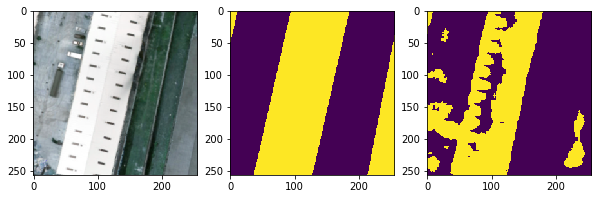

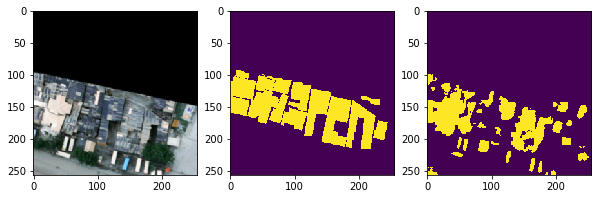

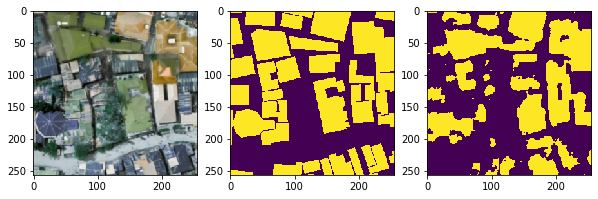

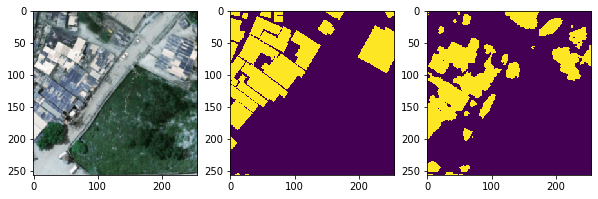

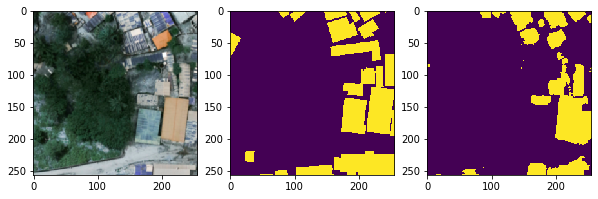

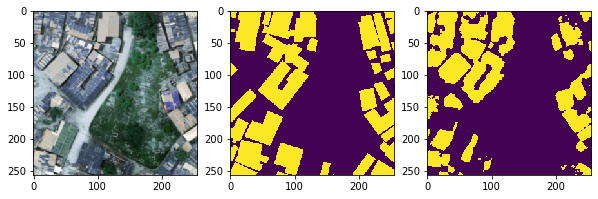

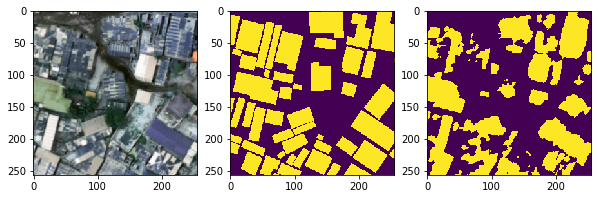

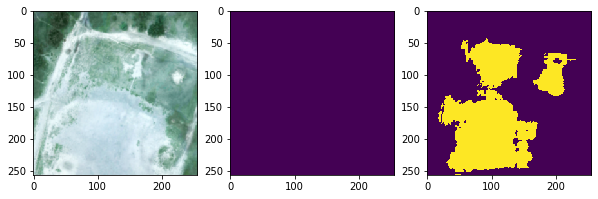

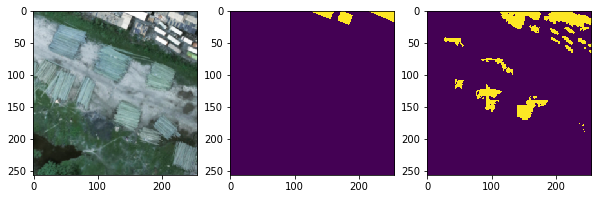

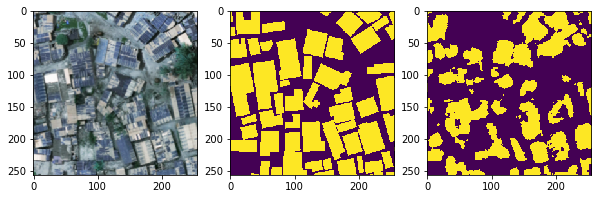

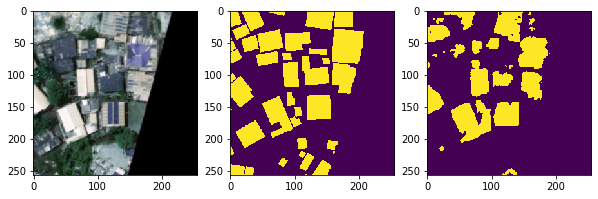

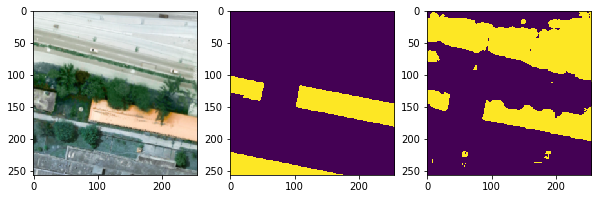

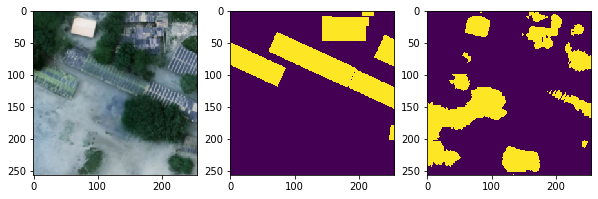

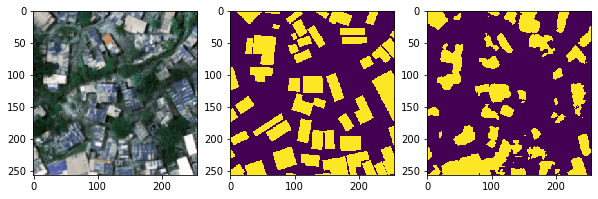

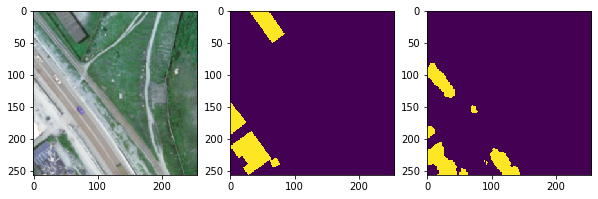

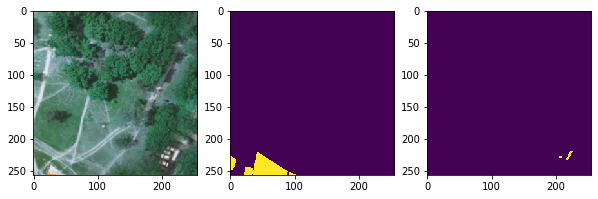

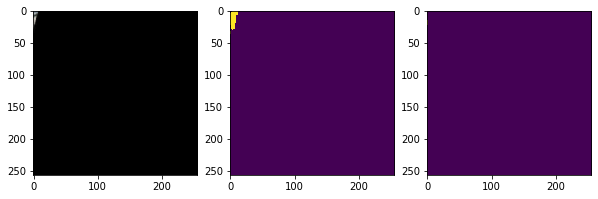

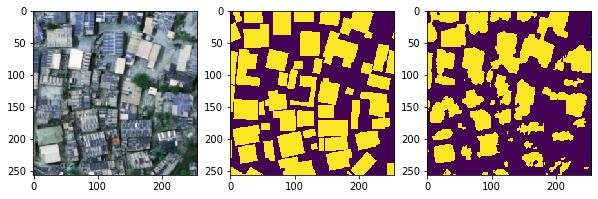

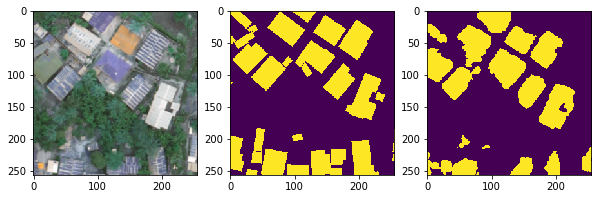

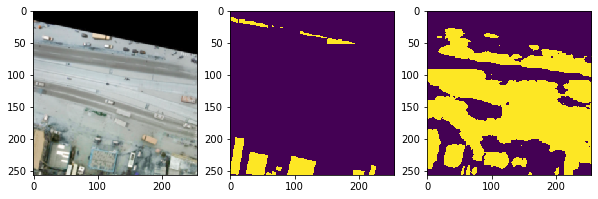

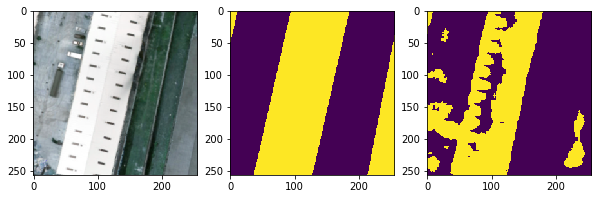

In [16]:
# Lấy ngẫu nhiên một số lượng ảnh trong kho --> test với mô hình model
## Đường dẫn thư mục chứa ảnh / và đổi tên đường dẫn thì được mask
im_folder = 'drive/My Drive/open_cities_compet/data/train/images-256-2/*.png' 
## số lượng ảnh đem đi test
subset_size = 20

all_im_num = len( glob.glob( im_folder ) )
print('Số lượng ảnh có trong kho train là: ', all_im_num)
im_list = get_subset(im_folder, subset_size)
evaluate_folder( model, im_list = im_list )

# Run model (Train + Test)
Sử dụng khi tạo model mới và train + test chung 1 session

In [0]:
# INPUT PARAMETERS
im_folder = 'drive/My Drive/open_cities_compet/data/train/images-256/*.png'
all_im_num = len( glob.glob( im_folder ) )
print('Số lượng ảnh có trong kho train là: ', all_im_num)
# Số lượng ảnh muốn train
# train_size = min( 1000 , all_im_num)
im_folder = im_list_storage
save_path = 'drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200301_unet_inception_0.9mprams_test.h5'
cv_segmentation = dac_model(model)
cv_segmentation.run_model( im_folder , chunk_size = 100, eval = 0.1, subset_size = 1000, epochs = 5, chunk_epochs = 2, batch_size = 10, save_path = save_path, test_size = 0.1, dense_min =0.3 )
cv_segmentation.model.save( save_path )

Số lượng ảnh có trong kho train là:  14328
----------[B1. Cắt lấy subset]----------
----------[B2. Tách train/test]----------
----------[B3. Training và lưu lại kết quả]----------
---------- Training at global epoch:  1  /  5 , chunk:  1 /  10 ----------
Train on 91 samples, validate on 10 samples
Epoch 1/2
91/91 [==============================] - 11s 122ms/step - loss: 0.9019 - acc: 0.7510 - iou_coef: 0.5536 - val_loss: 0.9173 - val_acc: 0.7526 - val_iou_coef: 0.5566
Epoch 2/2
91/91 [==============================] - 11s 121ms/step - loss: 0.8976 - acc: 0.7506 - iou_coef: 0.5553 - val_loss: 0.9285 - val_acc: 0.7281 - val_iou_coef: 0.5467
---------- Training at global epoch:  1  /  5 , chunk:  2 /  10 ----------
Train on 91 samples, validate on 10 samples
Epoch 1/2
91/91 [==============================] - 11s 121ms/step - loss: 0.9251 - acc: 0.7391 - iou_coef: 0.5610 - val_loss: 0.9411 - val_acc: 0.7342 - val_iou_coef: 0.5262
Epoch 2/2
91/91 [==============================] - 11s 121ms

In [0]:
im_list_storage = cv_segmentation.im_list

In [0]:
np.savez('/content/drive/My Drive/open_cities_compet/model/prams/20200301_unet_inception_0.9mprams_test.npy', np.array(im_list_storage))

In [0]:
save_path = 'drive/My Drive/open_cities_compet/model/Unet_n_derivative/20200301_unet_inception_0.9mprams_test.h5'
cv_segmentation.model.save( save_path )

In [0]:
dac_model()

In [9]:
import glob
im_folder = 'drive/My Drive/open_cities_compet/data/train/images-256/*.png'
all_ims = glob.glob( im_folder )
len(all_ims)

23861

In [0]:
import shutil
from random import choice

In [20]:
shutil.move( all_ims[0].replace('images', 'masks').replace('.png', '_mask.png') , '/content/drive/My Drive/open_cities_compet/data/train/masks-256-3' )

'/content/drive/My Drive/open_cities_compet/data/train/masks-256-3/dar_0ccd08_764_19_319258_272088_mask.png'

In [0]:
moved_list = glob.glob( '/drive/My Drive/open_cities_compet/data/train/images-256-3/*.pnj' )
for i in range(5000):
  im = choice(all_ims)
  if im not in moved_list:
    try:
      mask = im.replace('images', 'masks').replace('.png', '_mask.png')
      shutil.move( im, '/content/drive/My Drive/open_cities_compet/data/train/images-256-3' )
      shutil.move( mask, '/content/drive/My Drive/open_cities_compet/data/train/masks-256-3'  )
    except: pass
  moved_list = glob.glob( '/drive/My Drive/open_cities_compet/data/train/images-256-3/*.pnj' )

# Predict
Predict kết quả của test_set và lưu lại thành file .zip trong drive